## Gaussian processes with genetic algorithm for the reconstruction of late-time Hubble data

This notebook uses Gaussian processes (GP) with the genetic algorithm (GA) to reconstruct the cosmic chronometers and supernovae data sets ([2106.08688](https://arxiv.org/abs/2106.08688)). We shall construct our own GP class and use it with the python package ``pygad`` (https://pygad.readthedocs.io/) for the GA.

References to the data can be found at the end of the notebook.

In [1]:
%matplotlib inline
import numpy as np
from numpy.random import uniform as unif
import matplotlib.pyplot as plt
import pygad

### 0. My GP class

Here is the GP class (written from scratch) that we shall use in this notebook.

In [2]:
class GP:
    '''Class for making GP predictions.
    
    rbf: k(r) = A^2 \exp(-r^2/(2l^2))
    rq : k(r) = A^2 (1 + (r^2/(2 \alpha l^2)))^{-\alpha}
    m52: k(r) = A^2 \exp(-\sqrt{5}r/l)
                (1 + \sqrt{5}r/l + 5r^2/(3l^2))
    mix: rbf + chy + m52
    
    Input:
    chromosome: list of kernel hyperparameters 
    '''
    
    def __init__(self, chromosome):
        self.C_rbf = chromosome[0] # rbf genes
        self.l_rbf = chromosome[1]
        self.n_rbf = chromosome[2]
        self.C_rq = chromosome[3] # rq genes
        self.l_rq = chromosome[4]
        self.a_rq = chromosome[5]
        self.n_rq = chromosome[6]
        self.C_m52 = chromosome[7] # m52 genes
        self.l_m52 = chromosome[8]
        self.n_m52 = chromosome[9]
        
    def kernel(self, x, y):
        r = x - y
        # rbf term
        k_rbf = np.exp(-(r**2)/(2*(self.l_rbf**2)))
        rbf_term = (self.C_rbf**2)*(k_rbf**self.n_rbf)
        # rq term
        r = x - y
        R_sq = (r**2)/(2*(self.l_rq**2))
        k_rq = 1/((1 + R_sq/self.a_rq)**self.a_rq)
        rq_term = (self.C_rq**2)*(k_rq**self.n_rq)
        # m52 term
        X = np.sqrt(5)*np.abs(r)/self.l_m52
        B = 1 + X + ((X**2)/3)
        k_m52 = B*np.exp(-X)
        m52_term = (self.C_m52**2)*(k_m52**self.n_m52)
        return rbf_term + rq_term + m52_term
    
    def k_plus_c_inv(self, Z, C):
        k_ZZ = np.array([[self.kernel(z_i, z_j) \
                          for z_i in Z]
                         for z_j in Z])
        return np.linalg.inv(k_ZZ + C)
    
    def cov(self, Z, C, Zs):
        '''Returns the covariance matrix at Zs.
        
        Note: Zs must be an array.'''
        kpc_inv = self.k_plus_c_inv(Z, C)
        return np.array([[self.kernel(z_i, z_j) \
                          -(self.kernel(z_i, Z) @ \
                            kpc_inv @ \
                            self.kernel(Z, z_j)) \
                          for z_i in Zs] \
                         for z_j in Zs])
    
    def var(self, Z, C, Zs):
        '''Returns the variance at Zs.
        
        Note: Zs must be an array.'''
        kpc_inv = self.k_plus_c_inv(Z, C)
        return np.array([self.kernel(zs, zs) \
                         -(self.kernel(zs, Z) @ \
                           kpc_inv @ \
                           self.kernel(Z, zs)) \
                         for zs in Zs])
    
    def get_logmlike(self, Z, Y, C):
        '''Returns the log-marginal likelihood.'''
        kpc_inv = self.k_plus_c_inv(Z, C)
        kpc = np.linalg.inv(kpc_inv)
        kpc_det = np.linalg.det(kpc)
        Ys = np.array([(self.kernel(zs, Z) @ kpc_inv \
                        @ Y) for zs in Z])
        delta_y = Y
        return -0.5*(delta_y @ kpc_inv @ delta_y) \
               -0.5*np.log(kpc_det) \
               -0.5*len(Z)*np.log(2*np.pi)
    
    def predict(self, Z, Y, C, Zs, with_cov = False, \
                k_as_cov = False):
        kpc_inv = self.k_plus_c_inv(Z, C)
        mean = np.array([(self.kernel(zs, Z) @ kpc_inv \
                          @ Y) for zs in Zs])
        if with_cov == False:
            var_zz = self.var(Z, C, Zs)
            return {'z': Zs, 'Y': mean, \
                    'varY': var_zz}
        elif (with_cov == True) and (k_as_cov == False):
            cov_zz = self.cov(Z, C, Zs)
            return {'z': Zs, 'Y': mean, \
                    'covY': cov_zz}
        elif (with_cov == True) and (k_as_cov == True):
            cov_zz = np.array([[self.kernel(z_i, z_j) \
                                for z_i in Zs] \
                               for z_j in Zs])
            return {'z': Zs, 'Y': mean, \
                    'covY': cov_zz}

This will be used for both the cosmic chronometers (Section 1) and supernovae applications (Section 2).

### 1. Cosmic chronometers

Importing the cosmic chronometers data set.

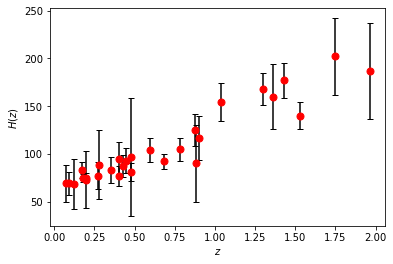

In [3]:
cc_data = np.loadtxt('cc_data.txt')

z_cc = cc_data[:, 0]
Hz_cc = cc_data[:, 1]
sigHz_cc = cc_data[:, 2]

fig, ax = plt.subplots()
ax.errorbar(z_cc, Hz_cc, yerr = sigHz_cc,
            fmt = 'ro', ecolor = 'k',
            markersize = 7, capsize = 3)
ax.set_xlabel('$z$')
ax.set_ylabel('$H(z)$')
plt.show()

To use the GA, we setup the log-marginal likelihood as a fitness function. In addition, we consider a Bayesian-information type penalty to fine complex kernels.

In [4]:
n_data = len(z_cc)

def penalty(chromosome):
    '''Identifies a penalty term to be factored in the fitness function
    so that longer/more complex kernels will be given a due weight.'''

    c_rbf = chromosome[0]
    l_rbf = chromosome[1]
    A_rbf = c_rbf*l_rbf

    c_rq = chromosome[3]
    l_rq = chromosome[4]
    A_rq = c_rq*l_rq
    
    c_m52 = chromosome[7]
    l_m52 = chromosome[8]
    A_m52 = c_m52*l_m52
    
    # set threshold to A_X = c_x*l_x
    A_th = 1e-3
    k = 0
    if A_rbf > A_th:
        k += 3
    if A_rq > A_th:
        k += 4
    if A_m52 > A_th:
        k += 3
        
    return k*np.log(n_data)/2

def get_fit(chromosome):
    '''Evaluates the fitness of the indivial with chromosome'''
    if all(hp > 0 for hp in chromosome) == True:
        pnl = penalty(chromosome)
        try:
            gp = GP(chromosome)
            lml = gp.get_logmlike(z_cc, Hz_cc,
                                  np.diag(sigHz_cc**2))
            return lml - pnl
        except:
            lml = -1000
            return lml
    else:
        lml = -1000
        return lml
    
def fitness_function(chromosome, chromosome_idx):
    return get_fit(chromosome)

In the next line, we setup an equally uniform population of pure-bred kernels and a diverse set of kernels. It is interesting to see the evolution of the uniform population compared to one which is a lot more diverse.

In [5]:
pop_size = 1000 # population size

init_uni = []
for i in range(0, pop_size):
    if i < int(pop_size/3):
        init_uni.append([unif(0, 300), unif(0, 10), unif(0, 5),
                         0, 0, 0, 0, 0, 0, 0])
    elif (i > int(pop_size/3)) and (i < int(2*pop_size/3)):
        init_uni.append([0, 0, 0,
                         unif(0, 300), unif(0, 10), unif(0, 2), unif(0, 5),
                         0, 0, 0])
    else:
        init_uni.append([0, 0, 0, 0, 0, 0, 0,
                         unif(0, 300), unif(0, 10), unif(0, 5)])
init_uni = np.array(init_uni)

init_div = []
for i in range(0, pop_size):
    init_div.append([unif(0, 300), unif(0, 10), unif(0, 5),
                     unif(0, 300), unif(0, 10), unif(0, 2), unif(0, 5),
                     unif(0, 300), unif(0, 10), unif(0, 5)])
init_div = np.array(init_div)

Given this, we prepare the parameters of the GA.

In [6]:
gene_space = [{'low': 0, 'high': 300}, {'low': 0, 'high': 10}, {'low': 0, 'high': 5}, # rbf lims
              {'low': 0, 'high': 300}, {'low': 0, 'high': 10}, # chy lims
              {'low': 0, 'high': 2}, {'low': 0, 'high': 5}, 
              {'low': 0, 'high': 300}, {'low': 0, 'high': 10}, {'low': 0, 'high': 5}] # m52 lims

num_genes = 10 # length of chromosome

n_gen = 100 # number of generations
sel_rate = 0.3 # selection rate
    
# parent selection
parent_selection_type = "rws" # roulette wheel selection
keep_parents = int(sel_rate*pop_size)
num_parents_mating = int(sel_rate*pop_size)

# crossover
#crossover_type = "single_point"
#crossover_type = "two_points"
#crossover_type = "uniform"
crossover_type = "scattered"
crossover_prob = 1.0

# mutation type options: random, swap, inversion, scramble, adaptive
mutation_type = "random"
#mutation_type = "swap"
#mutation_type = "inversion"
#mutation_type = "scramble"
#mutation_type = "adaptive"
mutation_prob = 0.5

def callback_generation(ga_instance):
    i_gen = ga_instance.generations_completed
    if i_gen in [i for i in range(0, n_gen, int(n_gen*0.1))]:
        last_best = ga_instance.best_solutions[-1]
        print("generation = {generation}".format(generation = i_gen))
        print("fitness    = {fitness}".format(fitness = get_fit(last_best)))

The ``GA run`` is performed in the next line.

*The next two code runs may be skipped if output have already been saved. In this case, proceed to the loading lines.

In [ ]:
# setup GA instance, for random initial pop.
ga_inst_uni_cc = pygad.GA(initial_population = init_uni,
                          num_genes = num_genes,
                          num_generations = n_gen,
                          num_parents_mating = num_parents_mating,
                          fitness_func = fitness_function,
                          parent_selection_type = parent_selection_type,
                          keep_parents = keep_parents,
                          crossover_type = crossover_type,
                          crossover_probability = crossover_prob,
                          mutation_type = mutation_type,
                          mutation_probability = mutation_prob,
                          mutation_by_replacement = True,
                          on_generation = callback_generation,
                          gene_space = gene_space,
                          save_best_solutions = True)

# perform GA run
ga_inst_uni_cc.run()

# save results
ga_inst_uni_cc.save('gp_ga_cc_uniform_init')

# best solution
solution = ga_inst_uni_cc.best_solutions[-1]
print("best chromosome: {solution}".format(solution = solution))
print("best fitness = {solution_fitness}".format(solution_fitness = \
                                                 get_fit(solution)))

Next run creates a GA instance with the same parameters as with the previous run, but a a diversified initial population.

In [ ]:
ga_inst_div_cc = pygad.GA(initial_population = init_div,
                          num_genes = num_genes,
                          num_generations = n_gen,
                          num_parents_mating = num_parents_mating,
                          fitness_func = fitness_function,
                          parent_selection_type = parent_selection_type,
                          keep_parents = keep_parents,
                          crossover_type = crossover_type,
                          crossover_probability = crossover_prob,
                          mutation_type = mutation_type,
                          mutation_probability = mutation_prob,
                          mutation_by_replacement = True,
                          on_generation = callback_generation,
                          gene_space = gene_space,
                          save_best_solutions = True)

# perform GA run
ga_inst_div_cc.run()

# save results
ga_inst_div_cc.save('gp_ga_cc_diverse_init')

# best solution
solution = ga_inst_div_cc.best_solutions[-1]
print("best chromosome: {solution}".format(solution = solution))
print("best fitness = {solution_fitness}".format(solution_fitness = \
                                                 get_fit(solution)))

``Loading lines``

We can load the ``pygad`` results should they have been saved already in previous runs.

In [7]:
load_ga_uniform = pygad.load('gp_ga_cc_uniform_init')
load_ga_diverse = pygad.load('gp_ga_cc_diverse_init')

We can view the prediction based on this superior individual below.

uniform
H0 = 69.7 +/- 6.3
log-marginal likelihood -123.7946112476086
penalty 16.83647914993237
fitness function -140.63109039754096
chi^2 12.241263910472332

diverse
H0 = 67.3 +/- 5.9
log-marginal likelihood -123.76904376987132
penalty 16.83647914993237
fitness function -140.6055229198037
chi^2 12.30756281659826



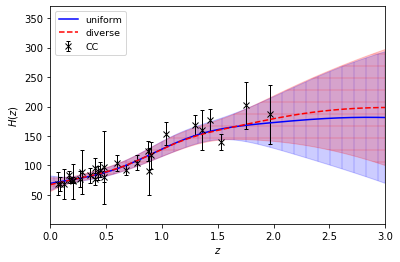

In [8]:
# champion chromosomes
chr_1 = load_ga_uniform.best_solutions[-1]
chr_2 = load_ga_diverse.best_solutions[-1]

z_min = 0
z_max = 3
n_div = 1000
z_rec = np.linspace(z_min, z_max, n_div)

champs = {}
champs['uniform'] = {'chromosome': chr_1}
champs['diverse'] = {'chromosome': chr_2}

for champ in champs:
    chromosome = champs[champ]['chromosome']
    gp = GP(chromosome)
    rec = gp.predict(z_cc, Hz_cc, np.diag(sigHz_cc**2),
                     z_rec)
    Hz_rec, sigHz_rec = rec['Y'], np.sqrt(rec['varY'])
    H0 = Hz_rec[0]
    sigH0 = sigHz_rec[0]
    
    # compute chi2
    Hz = gp.predict(z_cc, Hz_cc, np.diag(sigHz_cc**2),
                    z_cc)['Y']
    chi2 = np.sum(((Hz - Hz_cc)/sigHz_cc)**2)
    
    # print GA measures
    print(champ)
    print('H0 =', np.round(H0, 1), '+/-', np.round(sigH0, 1))
    print('log-marginal likelihood',
          gp.get_logmlike(z_cc, Hz_cc, np.diag(sigHz_cc**2)))
    print('penalty', penalty(chromosome))
    print('fitness function', get_fit(chromosome))
    print('chi^2', chi2)
    print()
    
    champs[champ]['z'] = z_rec
    champs[champ]['Hz'] = Hz_rec
    champs[champ]['sigHz'] = sigHz_rec

# plot champs' predictions
    
fig, ax = plt.subplots()
ax.errorbar(z_cc, Hz_cc, yerr = sigHz_cc,
            fmt = 'kx', ecolor = 'k',
            elinewidth = 1, capsize = 2, label = 'CC')
# color, line style, and hatch list
clst = ['b', 'r']
llst = ['-', '--']
hlst = ['|', '-']
for champ in champs:
    i = list(champs.keys()).index(champ)
    Hz_rec = champs[champ]['Hz']
    sigHz_rec = champs[champ]['sigHz']
    ax.plot(z_rec, Hz_rec, clst[i] + llst[i],
            label = champ)
    ax.fill_between(z_rec,
                    Hz_rec - 2*sigHz_rec,
                    Hz_rec + 2*sigHz_rec,
                    facecolor = clst[i], alpha = 0.2,
                    edgecolor = clst[i], hatch = hlst[i])
ax.set_xlabel('$z$')
ax.set_xlim(z_min, z_max)
ax.set_ylim(1, 370)
ax.set_ylabel('$H(z)$')
ax.legend(loc = 'upper left', prop = {'size': 9.5})
plt.show()

A plot of the generation vs fitness can also be shown.

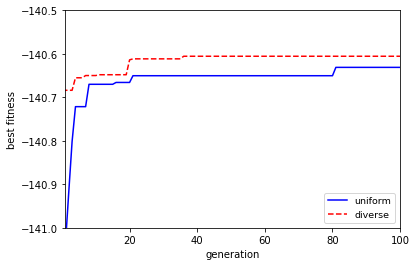

In [9]:
fit_uni = [get_fit(c) for c in load_ga_uniform.best_solutions]
fit_div = [get_fit(c) for c in load_ga_diverse.best_solutions]

fig, ax = plt.subplots()
ax.plot(fit_uni, 'b-', label = 'uniform')
ax.plot(fit_div, 'r--', label = 'diverse')
ax.set_xlabel('generation')
ax.set_ylabel('best fitness')
ax.set_xlim(1, n_gen)
ax.set_ylim(-141.0, -140.5)
ax.legend(loc = 'lower right', prop = {'size': 9.5})
plt.show()

### 2. Supernovae Type Ia

In this section, we perform the GP reconstruction with the compressed Pantheon data set.

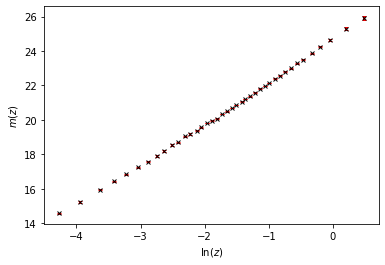

In [10]:
# load pantheon compressed m(z) data
loc_lcparam = 'lcparam_DS17f.txt'
loc_lcparam_sys = 'sys_DS17f.txt'
lcparam = np.loadtxt(loc_lcparam, usecols = (1, 4, 5))
lcparam_sys = np.loadtxt(loc_lcparam_sys, skiprows = 1)

# setup pantheon samples
z_ps = lcparam[:, 0]
logz_ps = np.log(z_ps)
mz_ps = lcparam[:, 1]
sigmz_ps = lcparam[:, 2]

# pantheon samples systematics
covmz_ps_sys = lcparam_sys.reshape(40, 40)
covmz_ps_tot = covmz_ps_sys + np.diag(sigmz_ps**2)

# plot data set
plt.errorbar(logz_ps, mz_ps,
             yerr = np.sqrt(np.diag(covmz_ps_tot)),
             fmt = 'kx', markersize = 4,
             ecolor = 'red', elinewidth = 2, capsize = 2)
plt.xlabel('$\ln(z)$')
plt.ylabel('$m(z)$')
plt.show()

The fitness function, now taking in the SNe data set, is prepared below for the GA.

In [11]:
n_data = len(z_ps)

def get_fit(chromosome):
    '''Evaluates the fitness of the indivial with chromosome'''
    if all(hp > 0 for hp in chromosome) == True:
        pnl = penalty(chromosome)
        try:
            gp = GP(chromosome)
            lml = gp.get_logmlike(logz_ps, mz_ps,
                                  covmz_ps_tot)
            if np.isnan(lml) == False:
                return lml - pnl
            else:
                return -1000
        except:
            lml = -1000
            return lml
    else:
        lml = -1000
        return lml
    
def fitness_function(chromosome, chromosome_idx):
    return get_fit(chromosome)

Then, we setup the initial uniform and diverse kernel populations.

In [12]:
pop_size = 1000 # population size

init_uni = []
for i in range(0, pop_size):
    if i < int(pop_size/3):
        init_uni.append([unif(0, 200), unif(0, 100), unif(0, 5),
                         0, 0, 0, 0, 0, 0, 0])
    elif (i > int(pop_size/3)) and (i < int(2*pop_size/3)):
        init_uni.append([0, 0, 0,
                         unif(0, 200), unif(0, 100), unif(0, 2), unif(0, 5),
                         0, 0, 0])
    else:
        init_uni.append([0, 0, 0, 0, 0, 0, 0,
                         unif(0, 200), unif(0, 100), unif(0, 5)])
init_uni = np.array(init_uni)

init_div = []
for i in range(0, pop_size):
    init_div.append([unif(0, 200), unif(0, 100), unif(0, 5),
                     unif(0, 200), unif(0, 100), unif(0, 2), unif(0, 5),
                     unif(0, 200), unif(0, 100), unif(0, 5)])
init_div = np.array(init_div)

The GA parameters can now be set for the SNe fitting.

In [13]:
gene_space = [{'low': 0, 'high': 200}, {'low': 0, 'high': 100}, {'low': 0, 'high': 5}, # rbf lims
              {'low': 0, 'high': 200}, {'low': 0, 'high': 100}, # chy lims
              {'low': 0, 'high': 2}, {'low': 0, 'high': 5}, 
              {'low': 0, 'high': 200}, {'low': 0, 'high': 100}, {'low': 0, 'high': 5}] # m52 lims

num_genes = 10 # length of chromosome

n_gen = 100 # number of generations
sel_rate = 0.3 # selection rate
    
# parent selection
parent_selection_type = "rws" # roulette wheel selection
keep_parents = int(sel_rate*pop_size)
num_parents_mating = int(sel_rate*pop_size)

# crossover
#crossover_type = "single_point"
#crossover_type = "two_points"
#crossover_type = "uniform"
crossover_type = "scattered"
crossover_prob = 1.0

# mutation type options: random, swap, inversion, scramble, adaptive
mutation_type = "random"
#mutation_type = "swap"
#mutation_type = "inversion"
#mutation_type = "scramble"
#mutation_type = "adaptive"
mutation_prob = 0.5

Here are the ``GA runs``. We start with the uniform population.

*Skip the runs and jump ahead to loading lines if results have already been prepared.

In [ ]:
ga_inst_uni_sn = pygad.GA(initial_population = init_uni,
                          num_genes = num_genes,
                          num_generations = n_gen,
                          num_parents_mating = num_parents_mating,
                          fitness_func = fitness_function,
                          parent_selection_type = parent_selection_type,
                          keep_parents = keep_parents,
                          crossover_type = crossover_type,
                          crossover_probability = crossover_prob,
                          mutation_type = mutation_type,
                          mutation_probability = mutation_prob,
                          mutation_by_replacement = True,
                          on_generation = callback_generation,
                          gene_space = gene_space,
                          save_best_solutions = True)

# perform GA run
ga_inst_uni_sn.run()

# save results
ga_inst_uni_sn.save('gp_ga_sn_uniform_init')

# best solution
solution = ga_inst_uni_sn.best_solutions[-1]
print("best chromosome: {solution}".format(solution = solution))
print("best fitness = {solution_fitness}".format(solution_fitness = \
                                                 get_fit(solution)))

Here is the GA run for a diversified initial population.

In [ ]:
ga_inst_div_sn = pygad.GA(initial_population = init_div,
                          num_genes = num_genes,
                          num_generations = n_gen,
                          num_parents_mating = num_parents_mating,
                          fitness_func = fitness_function,
                          parent_selection_type = parent_selection_type,
                          keep_parents = keep_parents,
                          crossover_type = crossover_type,
                          crossover_probability = crossover_prob,
                          mutation_type = mutation_type,
                          mutation_probability = mutation_prob,
                          mutation_by_replacement = True,
                          on_generation = callback_generation,
                          gene_space = gene_space,
                          save_best_solutions = True)

# perform GA run
ga_inst_div_sn.run()

# save results
ga_inst_div_sn.save('gp_ga_sn_diverse_init')

# best solution
solution = ga_inst_div_sn.best_solutions[-1]
print("best chromosome: {solution}".format(solution = solution))
print("best fitness = {solution_fitness}".format(solution_fitness = \
                                                 get_fit(solution)))

``Load GA runs``

Saved ``pygad`` output can be accessed. This is done for the SNe runs below.

In [14]:
load_ga_uniform = pygad.load('gp_ga_sn_uniform_init')
load_ga_diverse = pygad.load('gp_ga_sn_diverse_init')

The GP reconstructions are shown below.

uniform
log-marginal likelihood 62.18631886438317
penalty 18.44439727056968
fitness function 43.74192159381349
chi^2 35.429040731552476

diverse
log-marginal likelihood 62.55037313828511
penalty 18.44439727056968
fitness function 44.10597586771543
chi^2 34.62680636352342



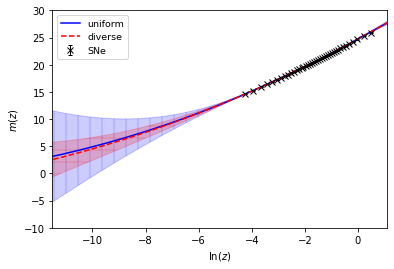

In [15]:
# champion chromosomes
chr_1 = load_ga_uniform.best_solutions[-1]
chr_2 = load_ga_diverse.best_solutions[-1]

z_min = 1e-5
z_max = 3
n_div = 1000
z_rec = np.logspace(np.log(z_min), np.log(z_max), n_div)
logz_rec = np.log(z_rec)

champs = {}
champs['uniform'] = {'chromosome': chr_1}
champs['diverse'] = {'chromosome': chr_2}

for champ in champs:
    chromosome = champs[champ]['chromosome']
    gp = GP(chromosome)
    rec = gp.predict(logz_ps, mz_ps, covmz_ps_tot,
                     logz_rec)
    mz_rec, sigmz_rec = rec['Y'], np.sqrt(rec['varY'])
    
    # compute chi2
    mz = gp.predict(logz_ps, mz_ps, covmz_ps_tot,
                    logz_ps)['Y']
    cov_inv = np.linalg.inv(covmz_ps_tot)
    delta_H = mz - mz_ps
    chi2 = ( delta_H @ cov_inv @ delta_H )
    
    # print GA measures
    print(champ)
    print('log-marginal likelihood',
          gp.get_logmlike(logz_ps, mz_ps, covmz_ps_tot))
    print('penalty', penalty(chromosome))
    print('fitness function', get_fit(chromosome))
    print('chi^2', chi2)
    print()
    
    champs[champ]['logz'] = logz_rec
    champs[champ]['mz'] = mz_rec
    champs[champ]['sigmz'] = sigmz_rec

# plot champs' predictions
    
fig, ax = plt.subplots()
ax.errorbar(logz_ps, mz_ps,
            yerr = np.sqrt(np.diag(covmz_ps_tot)),
            fmt = 'kx', ecolor = 'k',
            elinewidth = 1, capsize = 2, label = 'SNe')
# color, line style, and hatch list
clst = ['b', 'r']
llst = ['-', '--']
hlst = ['|', '-']
for champ in champs:
    i = list(champs.keys()).index(champ)
    mz_rec = champs[champ]['mz']
    sigmz_rec = champs[champ]['sigmz']
    ax.plot(logz_rec, mz_rec, clst[i] + llst[i],
            label = champ)
    ax.fill_between(logz_rec,
                    mz_rec - 2*sigmz_rec,
                    mz_rec + 2*sigmz_rec,
                    facecolor = clst[i], alpha = 0.2,
                    edgecolor = clst[i], hatch = hlst[i])
ax.set_xlabel('$\ln(z)$')
ax.set_ylabel('$m(z)$')
ax.set_xlim(np.log(z_min), np.log(z_max))
ax.set_ylim(-10, 30)
ax.legend(loc = 'upper left', prop = {'size': 9.5})
plt.show()

Here is the fitness per generation for the GPs above. 

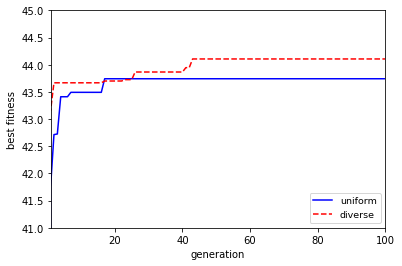

In [16]:
fit_uni = [get_fit(c) for c in load_ga_uniform.best_solutions]
fit_div = [get_fit(c) for c in load_ga_diverse.best_solutions]

fig, ax = plt.subplots()
ax.plot(fit_uni, 'b-', label = 'uniform')
ax.plot(fit_div, 'r--', label = 'diverse')
ax.set_xlabel('generation')
ax.set_ylabel('best fitness')
ax.set_xlim(1, n_gen)
ax.set_ylim(41, 45)
ax.legend(loc = 'lower right', prop = {'size': 9.5})
plt.show()

### References

***Pantheon***: D. M. Scolnic et al., The Complete Light-curve Sample of Spectroscopically Confirmed SNe Ia
from Pan-STARRS1 and Cosmological Constraints from the Combined Pantheon Sample,
Astrophys. J. 859 (2018) 101 [[1710.00845](https://arxiv.org/abs/1710.00845)].

***Cosmic Chronometers***, from *various sources*:

(1) M. Moresco, L. Pozzetti, A. Cimatti, R. Jimenez, C. Maraston, L. Verde et al., A 6%
measurement of the Hubble parameter at z ∼ 0.45: direct evidence of the epoch of cosmic
re-acceleration, JCAP 05 (2016) 014 [[1601.01701](https://arxiv.org/abs/1601.01701)].

(2) M. Moresco, Raising the bar: new constraints on the Hubble parameter with cosmic
chronometers at z ∼ 2, Mon. Not. Roy. Astron. Soc. 450 (2015) L16 [[1503.01116](https://arxiv.org/abs/1503.01116)].

(3) C. Zhang, H. Zhang, S. Yuan, S. Liu, T.-J. Zhang and Y.-C. Sun, Four new observational H(z)
data from luminous red galaxies in the Sloan Digital Sky Survey data release seven, Research in
Astronomy and Astrophysics 14 (2014) 1221 [[1207.4541](https://arxiv.org/abs/1207.4541)].

(4) D. Stern, R. Jimenez, L. Verde, M. Kamionkowski and S. A. Stanford, Cosmic chronometers:
constraining the equation of state of dark energy. I: H(z) measurements, JCAP 2010 (2010)
008 [[0907.3149](https://arxiv.org/abs/0907.3149)].

(5) M. Moresco et al., Improved constraints on the expansion rate of the Universe up to z ˜1.1 from
the spectroscopic evolution of cosmic chronometers, JCAP 2012 (2012) 006 [[1201.3609](https://arxiv.org/abs/1201.3609)].

(6) Ratsimbazafy et al. Age-dating Luminous Red Galaxies observed with the Southern African
Large Telescope, Mon. Not. Roy. Astron. Soc. 467 (2017) 3239 [[1702.00418](https://arxiv.org/abs/1702.00418)].